<a href="https://colab.research.google.com/github/Dedulus/Dedulus/blob/main/Distributed_Linear_Regression_Analysis_with_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Section III: Distributed Linear Regression Analysis**

Setting up the Google Colab VM(Virtual Machine) instance(which is running a Linux distribution) with required packages for working with Python & Spark

In [ ]:
# innstalling java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# installing spark spark-3.0.0 (also tried with older version but it failed to work hence using 3.0.0)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# Unzipping the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# Setting up the spark folder for system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# Installing Pyspark
!pip install -q findspark

Dataset Used: https://www.kaggle.com/datasets/quantbruce/real-estate-price-prediction?select=Real+estate.csv

Starting the Python session

In [ ]:
# Setting up Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [ ]:
# Initiating the Spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
#Please upload the file from local system to Google Colab(Real estate.csv)
from google.colab import files
files.upload()

Saving Real estate.csv to Real estate (1).csv


{'Real estate.csv': b'No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area\r\n1,2012.917,32,84.87882,10,24.98298,121.54024,37.9\r\n2,2012.917,19.5,306.5947,9,24.98034,121.53951,42.2\r\n3,2013.583,13.3,561.9845,5,24.98746,121.54391,47.3\r\n4,2013.500,13.3,561.9845,5,24.98746,121.54391,54.8\r\n5,2012.833,5,390.5684,5,24.97937,121.54245,43.1\r\n6,2012.667,7.1,2175.03,3,24.96305,121.51254,32.1\r\n7,2012.667,34.5,623.4731,7,24.97933,121.53642,40.3\r\n8,2013.417,20.3,287.6025,6,24.98042,121.54228,46.7\r\n9,2013.500,31.7,5512.038,1,24.95095,121.48458,18.8\r\n10,2013.417,17.9,1783.18,3,24.96731,121.51486,22.1\r\n11,2013.083,34.8,405.2134,1,24.97349,121.53372,41.4\r\n12,2013.333,6.3,90.45606,9,24.97433,121.5431,58.1\r\n13,2012.917,13,492.2313,5,24.96515,121.53737,39.3\r\n14,2012.667,20.4,2469.645,4,24.96108,121.51046,23.8\r\n15,2013.500,13.2,1164.838,4,24.99156,121.53406,34.3\r\n16,2013.583

In [ ]:
#Loading the CSV file, uploaded in previous step
data = spark.read.csv('Real estate.csv', header=True, inferSchema=True)

In [ ]:
#Taking a look at data type of each column to see what data types inferSchema paramter has set for each column
data.printSchema()

root
 |-- No: integer (nullable = true)
 |-- X1 transaction date: double (nullable = true)
 |-- X2 house age: double (nullable = true)
 |-- X3 distance to the nearest MRT station: double (nullable = true)
 |-- X4 number of convenience stores: integer (nullable = true)
 |-- X5 latitude: double (nullable = true)
 |-- X6 longitude: double (nullable = true)
 |-- Y house price of unit area: double (nullable = true)



In [ ]:
# Displaying the datatypes in a dataset
data.dtypes

[('No', 'int'),
 ('X1 transaction date', 'double'),
 ('X2 house age', 'double'),
 ('X3 distance to the nearest MRT station', 'double'),
 ('X4 number of convenience stores', 'int'),
 ('X5 latitude', 'double'),
 ('X6 longitude', 'double'),
 ('Y house price of unit area', 'double')]

In [ ]:
#Creating features storing categorical & numerical variables, omitting the last column
categorical_cols = [item[0] for item in data.dtypes if item[1].startswith('string')]
print(categorical_cols)

numerical_cols = [item[0] for item in data.dtypes if item[1].startswith('int') | item[1].startswith('double')]
print(numerical_cols)

[]
['No', 'X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude', 'Y house price of unit area']


In [ ]:
#Printing number of categorical as well as numerical features.
print(str(len(categorical_cols)) + '  categorical features')
print(str(len(numerical_cols)) + '  numerical features')

0  categorical features
8  numerical features


In [ ]:
#Display first few rows of data
data.show()

+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
| No|X1 transaction date|X2 house age|X3 distance to the nearest MRT station|X4 number of convenience stores|X5 latitude|X6 longitude|Y house price of unit area|
+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
|  1|           2012.917|        32.0|                              84.87882|                             10|   24.98298|   121.54024|                      37.9|
|  2|           2012.917|        19.5|                              306.5947|                              9|   24.98034|   121.53951|                      42.2|
|  3|           2013.583|        13.3|                              561.9845|                              5|   24.98746|   121.54391|                      47.3|
|  4|             2013.5|   

In [ ]:
# Dsscribing the data
data.describe()

DataFrame[summary: string, No: string, X1 transaction date: string, X2 house age: string, X3 distance to the nearest MRT station: string, X4 number of convenience stores: string, X5 latitude: string, X6 longitude: string, Y house price of unit area: string]

In [ ]:
# Importing the necessary Python libraries, reading the CSV file and generating the Descriptive Statistics of the data(Panda Dataframe)
import pandas as pd
data_panda=pd.read_csv('Real estate.csv')
data_panda.describe()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,207.500000,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,119.655756,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,1.000000,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,104.250000,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,207.500000,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,310.750000,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,414.000000,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


In [ ]:
# Printing the data types
data_panda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


In [ ]:
# I have also dropped "No" column as it will have no significance to the problem statement
data_panda.drop("No", axis=1, inplace=True)

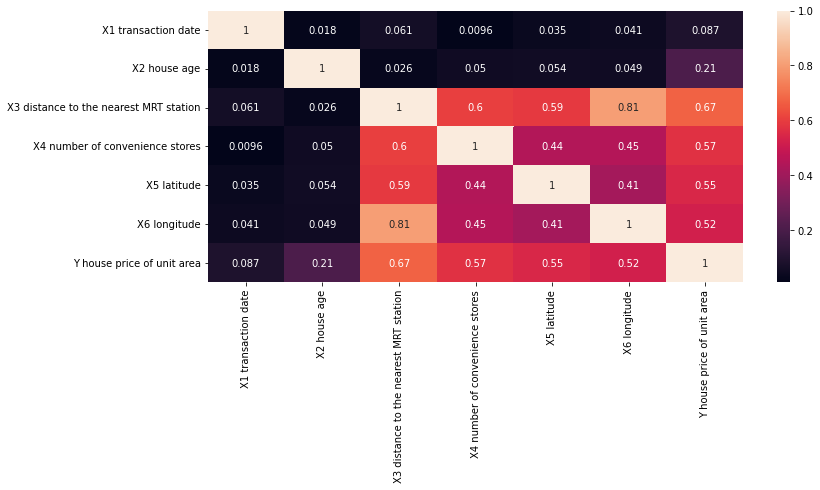

In [ ]:
#Generating Heatmap using the Seaborn Library
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 5))
sns.heatmap(abs(data_panda.corr()),  annot=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

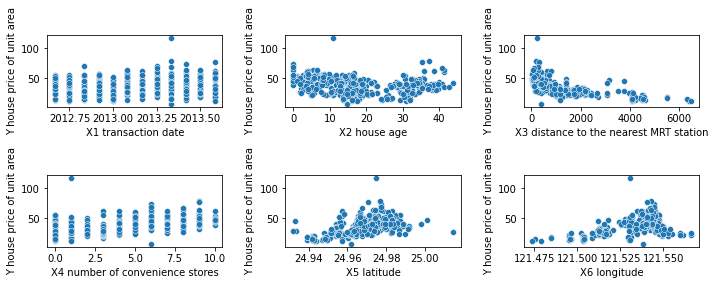

In [ ]:
#Scatter Plot of 'Y house price of unit area' with other columns
fig=plt.subplots(figsize=(10,25))
i=0
for feature in data_panda.columns:
    if feature not in ['Y house price of unit area']:
        i+=1
        plt.subplot(13, 3, i)
        sns.scatterplot(data_panda[feature],data_panda['Y house price of unit area'])
        plt.tight_layout()

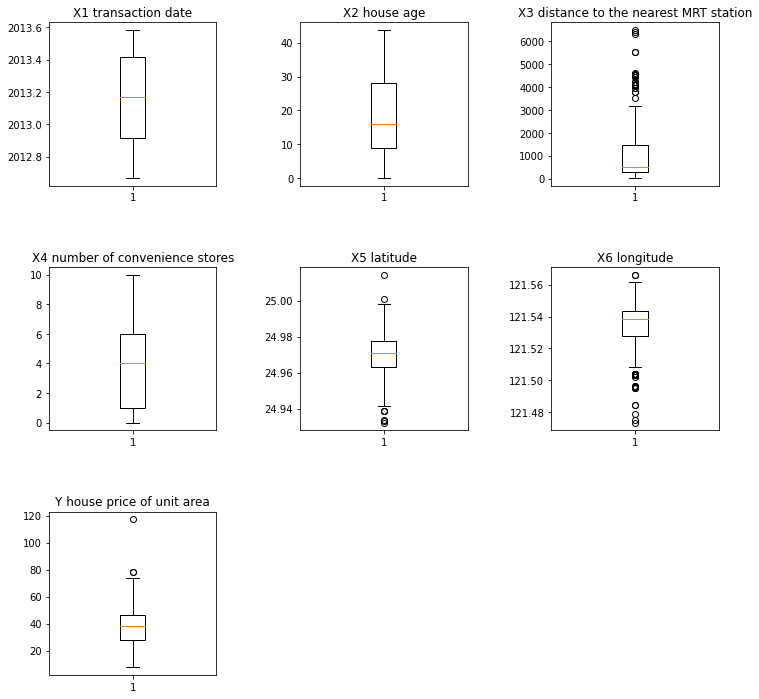

In [ ]:
#Boxplot of Y,X1,X2,X3,X4,X5,X6
l = [0,1,2,3,4,5,6]
plot = plt.figure(figsize = (12, 12))
plot.subplots_adjust(hspace = 0.5, wspace = 0.5)
for i in range(1, 8):
    a = plot.add_subplot(3, 3, i)
    a.boxplot(data_panda.iloc[: , l[i - 1]])
    a.title.set_text(data_panda.columns[l [i - 1]])

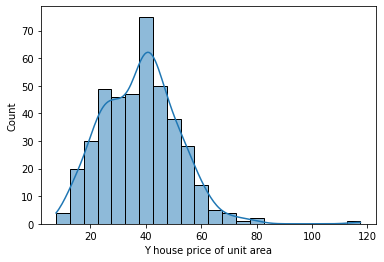

In [ ]:
#Plotting the Histogram of the dependend variable
sns.histplot(data=data_panda,x='Y house price of unit area',kde=True)

In [ ]:
#plotting on map

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

In [ ]:
# After experimenting with multiple values it was determined that the zoom factor 14 is optimal for representation
city= folium.Map(location=[24.98, 121.52], tiles='Stamen Toner', zoom_start=14)

In [ ]:
#Plotting the city in map using the Latitude and Longitude information from the dataframe
for i in range (0,len(data_panda)):
    
    lat=data_panda["X5 latitude"][i]
    long=data_panda["X6 longitude"][i]
    folium.Marker(
    [lat, long], ).add_to(city)

In [ ]:
#Displaying the location in map
city

In [ ]:
data_panda.corr()["Y house price of unit area"].sort_values(ascending=False)

Y house price of unit area                1.000000
X4 number of convenience stores           0.571005
X5 latitude                               0.546307
X6 longitude                              0.523287
X1 transaction date                       0.087491
X2 house age                             -0.210567
X3 distance to the nearest MRT station   -0.673613
Name: Y house price of unit area, dtype: float64

From the above Heatmap in cell 49 we observed that X6 has high correlation with X3 hence any one column can be dropped. In this case I have dropped "X6 longitude" column

I have also dropped "No" column as it will have no significance to the problem statement

In [ ]:
l=data.drop('No',"X6 longitude")

In [ ]:
l.show()

+-------------------+------------+--------------------------------------+-------------------------------+-----------+--------------------------+
|X1 transaction date|X2 house age|X3 distance to the nearest MRT station|X4 number of convenience stores|X5 latitude|Y house price of unit area|
+-------------------+------------+--------------------------------------+-------------------------------+-----------+--------------------------+
|           2012.917|        32.0|                              84.87882|                             10|   24.98298|                      37.9|
|           2012.917|        19.5|                              306.5947|                              9|   24.98034|                      42.2|
|           2013.583|        13.3|                              561.9845|                              5|   24.98746|                      47.3|
|             2013.5|        13.3|                              561.9845|                              5|   24.98746|             

In [ ]:
# Creating the  Feature array by omitting the last column
feature_cols = l.columns[:-1] 
from pyspark.ml.feature import VectorAssembler
vect_assembler = VectorAssembler(inputCols=feature_cols,outputCol="features")

In [ ]:
#Utilizinge Assembler created above in order to add the feature column
data_w_features = vect_assembler.transform(l)

In [ ]:
#Displaying the data having additional column named features. 
data_w_features.show()

+-------------------+------------+--------------------------------------+-------------------------------+-----------+--------------------------+--------------------+
|X1 transaction date|X2 house age|X3 distance to the nearest MRT station|X4 number of convenience stores|X5 latitude|Y house price of unit area|            features|
+-------------------+------------+--------------------------------------+-------------------------------+-----------+--------------------------+--------------------+
|           2012.917|        32.0|                              84.87882|                             10|   24.98298|                      37.9|[2012.917,32.0,84...|
|           2012.917|        19.5|                              306.5947|                              9|   24.98034|                      42.2|[2012.917,19.5,30...|
|           2013.583|        13.3|                              561.9845|                              5|   24.98746|                      47.3|[2013.583,13.3,56...|
|   

In [ ]:
#Selecting only Features and Label from previous dataset as we need these two entities for building the model
finalized_data = data_w_features.select("features","Y house price of unit area")

finalized_data.show()

+--------------------+--------------------------+
|            features|Y house price of unit area|
+--------------------+--------------------------+
|[2012.917,32.0,84...|                      37.9|
|[2012.917,19.5,30...|                      42.2|
|[2013.583,13.3,56...|                      47.3|
|[2013.5,13.3,561....|                      54.8|
|[2012.833,5.0,390...|                      43.1|
|[2012.667,7.1,217...|                      32.1|
|[2012.667,34.5,62...|                      40.3|
|[2013.417,20.3,28...|                      46.7|
|[2013.5,31.7,5512...|                      18.8|
|[2013.417,17.9,17...|                      22.1|
|[2013.083,34.8,40...|                      41.4|
|[2013.333,6.3,90....|                      58.1|
|[2012.917,13.0,49...|                      39.3|
|[2012.667,20.4,24...|                      23.8|
|[2013.5,13.2,1164...|                      34.3|
|[2013.583,35.7,57...|                      50.5|
|[2013.25,0.0,292....|                      70.1|


In [ ]:
#Splitting the data randomly into training and test set 
train_dataset, test_dataset = finalized_data.randomSplit([0.7, 0.3])

In [ ]:
#Peek of train_dataset
train_dataset.describe().show()

+-------+--------------------------+
|summary|Y house price of unit area|
+-------+--------------------------+
|  count|                       298|
|   mean|         38.29765100671141|
| stddev|        14.285823110286634|
|    min|                       7.6|
|    max|                     117.5|
+-------+--------------------------+



In [ ]:
#Peek of test_dataset
test_dataset.describe().show()

+-------+--------------------------+
|summary|Y house price of unit area|
+-------+--------------------------+
|  count|                       116|
|   mean|         37.16465517241378|
| stddev|         11.69950763966137|
|    min|                      12.8|
|    max|                      69.7|
+-------+--------------------------+



In [ ]:
#Importong the Linear Regression class 
from pyspark.ml.regression import LinearRegression

In [ ]:
#Creating the Linear Regression object
LinReg = LinearRegression(featuresCol="features", labelCol="Y house price of unit area")

In [ ]:
#Training the model on the training dataset using fit() method.
model = LinReg.fit(train_dataset)

In [ ]:
#Predtion using the evulate method
pred = model.evaluate(test_dataset)

In [ ]:
#Showing the predicted values alongside actual values for 20 Rows
pred.predictions.show(20)

+--------------------+--------------------------+------------------+
|            features|Y house price of unit area|        prediction|
+--------------------+--------------------------+------------------+
|[2012.667,3.1,577...|                      47.7| 44.23429713988662|
|[2012.667,7.1,217...|                      32.1|30.620567343892617|
|[2012.667,14.6,33...|                      26.5| 37.24815952026984|
|[2012.667,29.4,45...|                      13.2| 8.886063208028645|
|[2012.667,30.4,17...|                      25.9|25.631719785720634|
|[2012.667,37.1,91...|                      31.9|27.931955503037898|
|[2012.75,0.0,185....|                      52.2| 40.49444257898358|
|[2012.75,11.4,390...|                      46.8| 43.72637774703253|
|[2012.75,13.0,492...|                      40.5|40.098594643332035|
|[2012.75,15.4,205...|                      55.1| 46.70407406233062|
|[2012.75,16.1,406...|                      12.9|12.717112477206683|
|[2012.75,29.3,529...|            

In [ ]:
#Determining coefficient value
coefficient = model.coefficients
print ("The coefficient of the model is : %a" %coefficient)

The coefficient of the model is : DenseVector([6.613, -0.2667, -0.0047, 1.1284, 191.7926])


In [ ]:
#Determining intercept Value
intercept = model.intercept
print ("The Intercept of the model is : %f" %intercept)

The Intercept of the model is : -18058.322078


In [ ]:
#Evaluating the model using metric like Mean Absolute Error(MAE), Root Mean Square Error(RMSE) and R-Square
from pyspark.ml.evaluation import RegressionEvaluator
evaluation = RegressionEvaluator(labelCol="Y house price of unit area", predictionCol="prediction")

# Root Mean Square Error
rmse = evaluation.evaluate(pred.predictions, {evaluation.metricName: "rmse"})
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = evaluation.evaluate(pred.predictions, {evaluation.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = evaluation.evaluate(pred.predictions, {evaluation.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = evaluation.evaluate(pred.predictions, {evaluation.metricName: "r2"})
print("r2: %.3f" %r2)

RMSE: 6.677
MSE: 44.578
MAE: 5.516
r2: 0.671


From the above data we observe an optimal value of r2 as .67, which keeps changing wile executing the program multiple times.

In [ ]:
#Creating unlabeled dataset  to contain only feature column
unlabeled_dataset = test_dataset.select('features')

In [ ]:
#Displaying the content of unlabeled_dataset
unlabeled_dataset.show()

+--------------------+
|            features|
+--------------------+
|[2012.667,3.1,577...|
|[2012.667,7.1,217...|
|[2012.667,14.6,33...|
|[2012.667,29.4,45...|
|[2012.667,30.4,17...|
|[2012.667,37.1,91...|
|[2012.75,0.0,185....|
|[2012.75,11.4,390...|
|[2012.75,13.0,492...|
|[2012.75,15.4,205...|
|[2012.75,16.1,406...|
|[2012.75,29.3,529...|
|[2012.75,37.9,488...|
|[2012.833,0.0,185...|
|[2012.833,4.0,218...|
|[2012.833,12.7,18...|
|[2012.833,15.7,81...|
|[2012.833,15.9,14...|
|[2012.833,18.0,37...|
|[2012.833,18.4,26...|
+--------------------+
only showing top 20 rows



In [ ]:
#Predicting the model output for fresh & unseen test data using transform() method
new_predictions = model.transform(unlabeled_dataset)

In [ ]:
#Displaying the new prediction values
new_predictions.show()

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[2012.667,3.1,577...| 44.23429713988662|
|[2012.667,7.1,217...|30.620567343892617|
|[2012.667,14.6,33...| 37.24815952026984|
|[2012.667,29.4,45...| 8.886063208028645|
|[2012.667,30.4,17...|25.631719785720634|
|[2012.667,37.1,91...|27.931955503037898|
|[2012.75,0.0,185....| 40.49444257898358|
|[2012.75,11.4,390...| 43.72637774703253|
|[2012.75,13.0,492...|40.098594643332035|
|[2012.75,15.4,205...| 46.70407406233062|
|[2012.75,16.1,406...|12.717112477206683|
|[2012.75,29.3,529...| 42.00577035628521|
|[2012.75,37.9,488...|30.561487437291362|
|[2012.833,0.0,185...| 41.04332542777047|
|[2012.833,4.0,218...| 32.55715256254916|
|[2012.833,12.7,18...| 39.30859469885763|
|[2012.833,15.7,81...|39.919888416017784|
|[2012.833,15.9,14...| 33.86707708920221|
|[2012.833,18.0,37...| 47.36710428663355|
|[2012.833,18.4,26...|26.064219813131785|
+--------------------+------------

In [ ]:
# Importing the Matplotlib Library to plot the Actual vs Predicetd graph
import matplotlib.pyplot as plt

In [ ]:
#Preparing the data for plotting
mdata = model.transform(finalized_data)
mdata.show(3)

+--------------------+--------------------------+------------------+
|            features|Y house price of unit area|        prediction|
+--------------------+--------------------------+------------------+
|[2012.917,32.0,84...|                      37.9| 47.09635322898612|
|[2012.917,19.5,30...|                      42.2|47.761689743740135|
|[2013.583,13.3,56...|                      47.3|49.481056598979194|
+--------------------+--------------------------+------------------+
only showing top 3 rows



In [ ]:
#Declaring the Coordinates
x_ax = range(0, mdata.count())
y_pred = mdata.select("Y house price of unit area").collect()
y_orig = mdata.select("prediction").collect() 

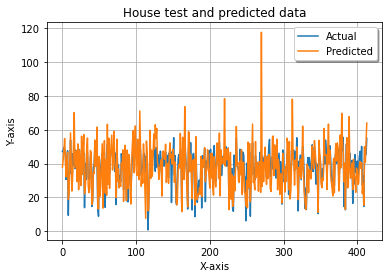

In [ ]:
#Plotting the actual vs predicted graph
plt.plot(x_ax, y_orig, label="Actual")
plt.plot(x_ax, y_pred, label="Predicted")
plt.title("House test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

In this project I have used two sets of Data Structure:

1.Pada Dataframe 
2.RDD Dataset

The Panda Dataframe was used in order to visualize the data and get insight from it and the RDD Dataset is used to perform Linear Regression operation using the MLLib library in a pseudo-distributed mode. I have tried and tested to work with a single dataset but it looks like either of them is not compatible with the other hence I had used both of them.
